# Image generation with DCGAN

This notebook shows how to implement a DCGAN based on Gluon. DCGAN is an extension of [GANs](https://arxiv.org/abs/1406.2661), where the generator and discriminator are Convolutional Neural Networks (CNN) (see [DCGAN Paper](https://arxiv.org/pdf/1511.06434.pdf)). 
DCGAN learns to draw images based on features it learns from different layers in the network. It can be used for generating natural images. This notebook is based on the DCGAN example from the [Straight Dope Book](https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html). 


In this example, you will learn to:

* Create a DCGAN - Define a Generator that creates images from random numbers. Define a Discriminator that determines if the image created by the Generator is real or fake.

* retrieve images of a dataset, pre-process them, and load them for training using a Data Loader.

* write a training loop for the GAN. 

* visualize images through the training process.

## Prerequisites

First, we will go ahead and install the CUDA-enabled version of MXNet "mxnet-cu92" to be able to execute our example on GPU. We are using [MXNet v1.4.1](http://mxnet.incubator.apache.org/versions/master/install/index.html).

To execute on CPU, install MXNet using
`pip install mxnet`. CUDA is not required in this case. Training time may be significantly larger when executed on CPU.

In [1]:
# !wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
# !dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
# !apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
# !apt-get update
# !apt-get install cuda-9.2
# !pip install mxnet-cu92

In [2]:
# !export PATH=/usr/local/cuda-9.2/bin:$PATH
# !nvcc --version

If ipywidgets is not available, execute the following step

In [3]:
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

Next, we import all the libraries required to execute our example.

We make use of [MXNet's Gluon API ](http://mxnet.incubator.apache.org/versions/master/gluon/index.html), which is a simple interface that makes it easy build and train models.

In [4]:
from __future__ import print_function
from datetime import datetime
import logging
logging.getLogger().setLevel(logging.INFO)
import multiprocessing
import os
import sys
import tarfile
import time

import numpy as np
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

## Hyperparameters

We then set some hyperparameters for training.

Every dataset is divided into one or more batches. The `batch_size` is the number of samples to process before updating the model. 

One scan through the entire dataset is called an `epoch`.

A `context` describes the device type and id on which computation should be carried on.

`z_dim` - how many random numbers we want to produce a single image from.

`lr` - learning rate used for training the model.

`beta` - The beta value used for `Adam Optimizer`. The [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) suggestes to use `Adam Optimizer` with `beta = 0.5`.

In [5]:
z_dim        = 100
ctx = [mx.gpu(i) for i in range(mx.context.num_gpus())] if mx.context.num_gpus() > 0 else [mx.cpu()]
epochs = 200
lr = 0.0002
beta = 0.5
batch_size = 64 * len(ctx) # We will load 64 samples on each GPU/CPU that we have chosen in the context.

In [6]:
logging.info('Total devices available to run on : %s' %(ctx))

INFO:root:Total devices available to run on : [gpu(0), gpu(1), gpu(2), gpu(3), gpu(4), gpu(5), gpu(6), gpu(7)]


## Download the dataset


You can plug in any dataset of your choice and execute this example. You are given an option to choose from any of the datasets in the dropdown below. 

To try out this example with your own dataset, pack the folder containing the images of your dataset into a .tgz file and modify the below code to unpack the .tgz file to automatically take your local dataset. Alternatively, mention the URL where the data is stored.

In [7]:
w = widgets.Dropdown(
    options=['Faces', 'Cartoon', 'Classroom', 'Flowers'],
    value='Flowers',
    description='Dataset:',
    disabled=False,
    button_style=''
)

display(w)


Dropdown(description='Dataset:', index=3, options=('Faces', 'Cartoon', 'Classroom', 'Flowers'), value='Flowers…

In [8]:
data_dir = '/tmp/' + w.value

In [9]:
data_url = 'https://s3.amazonaws.com/mxnet-conf-data/GAN_Meetup/'+w.value+'.tgz'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
data_file = utils.download(data_url)
with tarfile.open(data_file) as tar:
    tar.extractall(path=data_dir)

```visualize``` is a utility method to plot the images using ```matplotlib```. 
We will use this method to show the images generated by the GAN network as well.

In [10]:
def visualize(img_array):
    plt.imshow(((img_array.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

## Prepare the data

Let's start by preparing the images from the selected dataset. This is done so that all images are similar in terms of shape, color etc.

The first step is to resize the images to the same size of 64x64 as our GAN below takes inputs of size 64x64.

Most images saved are of the format `(height, width, channels)`, but for further processing by our model, we need a format `(channels, height, width)`, therefore, we transpose the image to get the  format that MXNet works with. More about reshape and transpose [here](https://mxnet.incubator.apache.org/versions/master/tutorials/basic/reshape_transpose.html).

Each pixel in our 64x64 image is represented by a number between 0-255, that represents the intensity of the pixel. However, we want to input numbers between -1 and 1 into our DCGAN, as suggested by the research paper. To rescale our pixels to be in the range of -1 to 1, we'll divide each pixel by (255/2). This put our images on a scale of 0-2. We can then subtract by 1, to get them in the range of -1 to 1.

We need to add 3 channels to our images. Typically when we are working with images, the 3 channels represent the red, green, and blue components. If the onput images are black and white (only 1 channel), we use `Tile` to pad the other channels with 0's. 

We then reshape the image to the `(batch, channel, height, width)` where batch is 1 (as we are processing 1 image) and return the result.

In [11]:
def transform(data, width=64, height=64):
    data = mx.image.imresize(data, width, height)
    data = nd.transpose(data, (2,0,1))
    data = data.astype(np.float32)/127.5 - 1
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

In [12]:
def get_files(data_dir):
    images    = []
    filenames = []
    for path, _, fnames in os.walk(data_dir):
        for fname in fnames:
            if not fname.endswith('.jpg'):
                continue
            img = os.path.join(path, fname)
            img_arr = mx.image.imread(img)
            img_arr = transform(img_arr)
            images.append(img_arr)
            filenames.append(path + "/" + fname)
    return images, filenames        

## Load the dataset

[Reference](http://mxnet.incubator.apache.org/versions/master/tutorials/gluon/datasets.html)

One of the most critical steps for model training and inference is loading the data.

Dataset objects are used to represent collections of data, and include methods to load and parse the data.

A DataLoader is used to create mini-batches of samples from a Dataset, and provides a convenient iterator interface for looping these batches. It’s typically much more efficient to pass a mini-batch of data through a neural network than a single sample at a time, because the computation can be performed in parallel.


We split the images into a batches and load them, with 64 * len(ctx) images in each batch (`batch_size`) mentioned in the hyperparameters above). Every time we iterate, we'll get a 4 dimensional array with size (64 * len(ctx), 3, 64, 64), representing a batch of 64 * len(ctx) images.


In [13]:
train_images, train_filenames = get_files(data_dir)

train_data = gluon.data.ArrayDataset(nd.concatenate(train_images))
train_dataloader = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, last_batch='rollover', num_workers=multiprocessing.cpu_count()-1)

Let's look at some samples of the training dataset

INFO:root:Total samples in the dataset : 8189


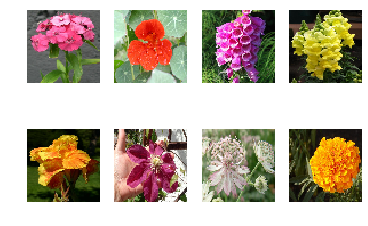

In [14]:
logging.info('Total samples in the dataset : %d' %(len(train_data)))
num_image = 8
for i in range(num_image):
    plt.subplot(2,4,i+1)
    visualize(train_data[i])
plt.show()

## Create the model

### Generator
Define the Generator model. Architecture is taken from the DCGAN implementation in [Straight Dope Book](https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html). The Generator consist of  4 layers where each layer involves a strided convolution, batch normalization, and rectified nonlinearity. It takes as input random noise and produces an `(64,64,3)` output image.



![alt text](https://github.com/yash1/mxnet-notebooks/raw/a2795a0cdc9e111b42b60fa6b1a4e6219df72afc/python/tutorials/dcgan-model.png)

Source: https://arxiv.org/abs/1511.06434


Our generator image starts with random numbers as input.

We then apply a Deconvolution layer, batch normalization and ReLU activation.

We repeat this process 4 times, applying a (2,2) stride and (1,1) pad at each Deconvolutional layer, which doubles the size of our image at each layer. We also reduce half the number of filters at each layer, reducing dimensionality at each layer. Ultimatley, our output layer is a 64x64x3 layer, representing the size and channels of our image. We use tanh activation instead of relu on the last layer, as recommended by the research on DCGANs. The output of neurons in the final out layer represents the pixels of generated image.

In [15]:
class Generator(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Generator, self).__init__(**kwargs)
        with self.name_scope():
            self.prev = nn.HybridSequential()
            self.prev.add(nn.Dense(1024, use_bias=False), nn.BatchNorm(), nn.Activation(activation='relu'))
            
            self.G = nn.HybridSequential()
            self.G.add(nn.Conv2DTranspose(channels=64 * 8, kernel_size=4, strides=1, padding=0, use_bias=False))
            self.G.add(nn.BatchNorm())
            self.G.add(nn.Activation('relu'))
            self.G.add(nn.Conv2DTranspose(channels=64 * 4, kernel_size=4, strides=2, padding=1, use_bias=False))
            self.G.add(nn.BatchNorm())
            self.G.add(nn.Activation('relu'))
            self.G.add(nn.Conv2DTranspose(channels=64 * 2, kernel_size=4, strides=2, padding=1, use_bias=False))
            self.G.add(nn.BatchNorm())
            self.G.add(nn.Activation('relu'))
            self.G.add(nn.Conv2DTranspose(channels=64 * 1, kernel_size=4, strides=2, padding=1, use_bias=False))
            self.G.add(nn.BatchNorm())
            self.G.add(nn.Activation('relu'))
            self.G.add(nn.Conv2DTranspose(channels=3, kernel_size=4, strides=2, padding=1, use_bias=False))
            self.G.add(nn.Activation('tanh'))

    def hybrid_forward(self, F, x):
        x = self.prev(x)
        x = F.reshape(x, (0, -1, 1, 1))
        return self.G(x)

### Discriminator

The discriminator works exactly the same way but in reverse - using convolutional layers instead of deconvolutional layers to take an image and determine if it is real or fake.

We start off by giving input images to the discriminator.

The discriminator then goes through a series of 4 convolutional layers, each with a 4x4 kernel, 2x2 stride, and 1x1 pad. These layers half the size of the image (which starts at 64x64) at each convolutional layer. Our model also increases dimensionality at each layer by doubling the number of filters per convolutional layer.

Finally, we flatten the neural net to get one number as the final output of discriminator network.

In [16]:
class Discriminator(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Discriminator, self).__init__(**kwargs)
        with self.name_scope():
            self.D = nn.HybridSequential()
            self.D.add(nn.Conv2D(channels=64 * 1, kernel_size=4, strides=2, padding=1, use_bias=False))
            self.D.add(nn.LeakyReLU(0.2))
            self.D.add(nn.Conv2D(channels=64 * 2, kernel_size=4, strides=2, padding=1, use_bias=False))
            self.D.add(nn.BatchNorm())
            self.D.add(nn.LeakyReLU(0.2))
            self.D.add(nn.Conv2D(channels=64 * 4, kernel_size=4, strides=2, padding=1, use_bias=False))
            self.D.add(nn.BatchNorm())
            self.D.add(nn.LeakyReLU(0.2))
            self.D.add(nn.Conv2D(channels=64 * 8, kernel_size=4, strides=2, padding=1, use_bias=False))
            self.D.add(nn.BatchNorm())
            self.D.add(nn.LeakyReLU(0.2))
            self.D.add(nn.Dense(units=1024, use_bias=False), nn.BatchNorm(), nn.Activation(activation='relu'))
            self.D.add(nn.Dense(units=1))

    def hybrid_forward(self, F, x):
          return self.D(x)

Initialize Generator and Discriminator and define correspoing trainer function.

Trainer applies an Optimizer on a set of Parameters. It takes the parameters to be optimized, optimizer to use, and parameters to the optimizer as arguments.

Here, we use the `adam` optimizer for gradient decent and set hyperparameters, `lr` and `beta1` based on the values used in the DCGAN paper. 

In [17]:
generator = Generator()
generator.hybridize()
generator.initialize(mx.init.Normal(sigma=0.002), ctx=ctx)

discriminator = Discriminator()
discriminator.hybridize()
discriminator.initialize(mx.init.Normal(sigma=0.002), ctx=ctx)

g_trainer = gluon.Trainer(generator.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta})
d_trainer = gluon.Trainer(discriminator.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta})

## Training the model

Create vectors with real (=1) and fake labels (=0).

In [18]:
# real_label = nd.ones((batch_size,))
real_label = nd.random.uniform(low = 0.70, high = 1.00, shape = (batch_size, ))
# Split the data across multiple GPUs
real_label = gluon.utils.split_and_load(data = real_label, ctx_list=ctx, even_split=False)

# fake_label = nd.zeros((batch_size,))
fake_label = nd.random.uniform(low = 0.0, high = 0.30, shape = (batch_size, ))
# Split the data across multiple GPUs
fake_label = gluon.utils.split_and_load(data = fake_label, ctx_list=ctx, even_split=False)

Define a loss function to determine by how much the Discriminator made a mistake while detecting a real/fake image.

In [19]:
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

Create random input for the Generator to start with

In [20]:
def create_generator_input():  
    #create random noise
    z      = nd.random_normal(0, 1, shape=(batch_size, z_dim, 1, 1))
    z = gluon.utils.split_and_load(data=z, ctx_list=ctx, even_split=False)
    return z

Define a custom accuracy metric. If the output of the Discriminator is greater than 0.5, then consider as a real image and compare it with the label to determine accuracy.

In [21]:
def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

Define the training loop. 
1. The discriminator receives `real_data` and `loss` measures how many real images have been identified as real
2. The discriminator receives `fake_image` from the Generator and `loss` measures how many fake images have been identified as fake
3. Update Discriminator.
4. The updated discriminator receives `fake_image` and `loss` measures how many fake images have been been identified as real.
5. Update Generator

INFO:root:Epoch # : 0
INFO:root:discriminator loss = 1.354407, generator loss = 0.725146, epoch 0


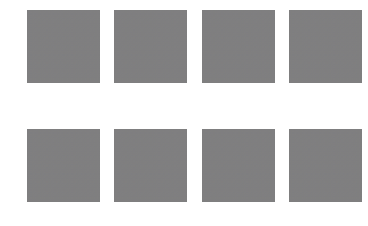

INFO:root:Epoch # : 10
INFO:root:discriminator loss = 1.008419, generator loss = 1.009196, epoch 10


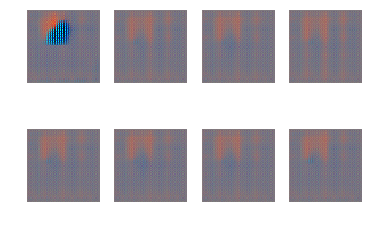

INFO:root:Epoch # : 20
INFO:root:discriminator loss = 1.165387, generator loss = 1.206411, epoch 20


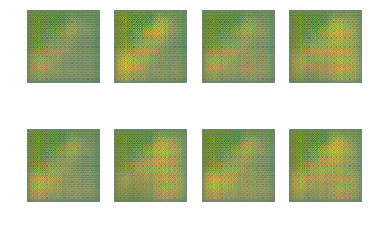

INFO:root:Epoch # : 30
INFO:root:discriminator loss = 0.913189, generator loss = 1.155066, epoch 30


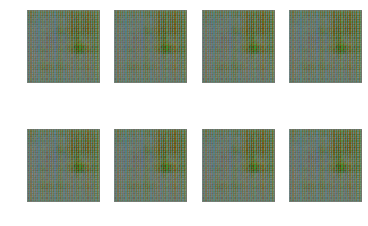

INFO:root:Epoch # : 40
INFO:root:discriminator loss = 0.877853, generator loss = 1.377113, epoch 40


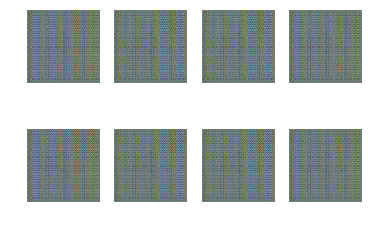

INFO:root:Epoch # : 50
INFO:root:discriminator loss = 1.082755, generator loss = 1.121611, epoch 50


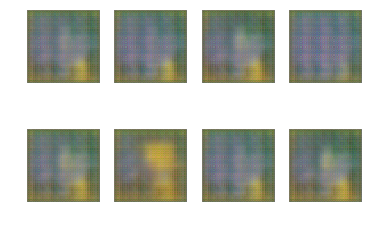

INFO:root:Epoch # : 60
INFO:root:discriminator loss = 1.347908, generator loss = 0.821728, epoch 60


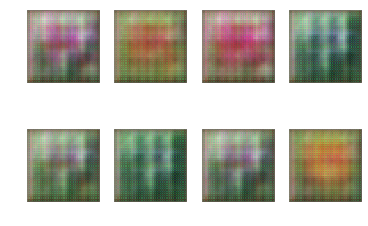

INFO:root:Epoch # : 70
INFO:root:discriminator loss = 1.366057, generator loss = 0.992303, epoch 70


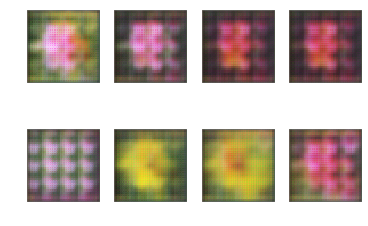

INFO:root:Epoch # : 80
INFO:root:discriminator loss = 1.233154, generator loss = 1.011428, epoch 80


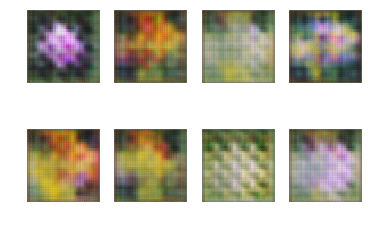

INFO:root:Epoch # : 90
INFO:root:discriminator loss = 1.204043, generator loss = 0.938029, epoch 90


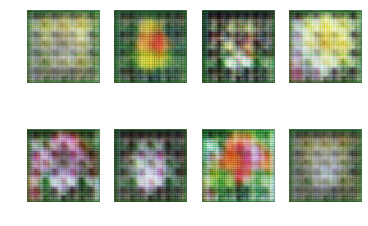

INFO:root:Epoch # : 100
INFO:root:discriminator loss = 1.223226, generator loss = 0.993134, epoch 100


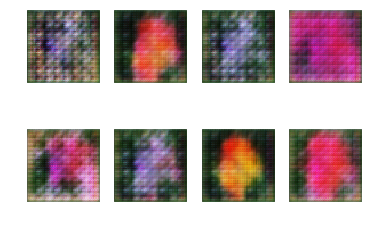

INFO:root:Epoch # : 110
INFO:root:discriminator loss = 1.249979, generator loss = 0.927220, epoch 110


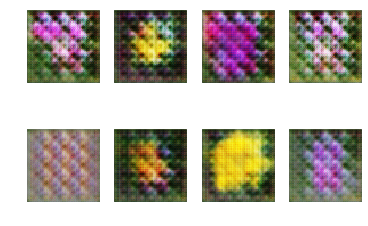

INFO:root:Epoch # : 120
INFO:root:discriminator loss = 1.303049, generator loss = 0.708010, epoch 120


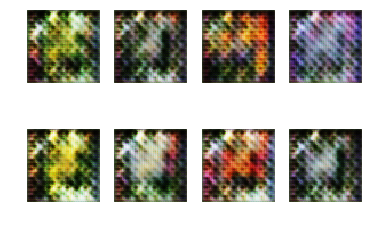

INFO:root:Epoch # : 130
INFO:root:discriminator loss = 1.222614, generator loss = 1.062684, epoch 130


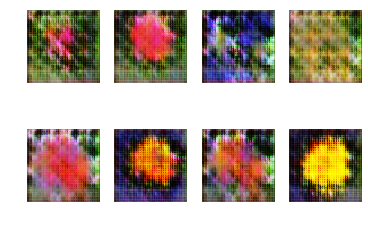

INFO:root:Epoch # : 140
INFO:root:discriminator loss = 1.385246, generator loss = 1.409566, epoch 140


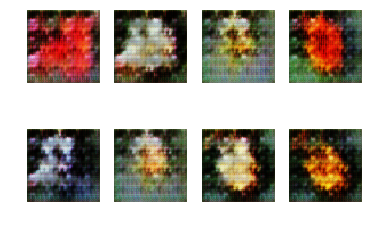

INFO:root:Epoch # : 150
INFO:root:discriminator loss = 1.136139, generator loss = 1.214724, epoch 150


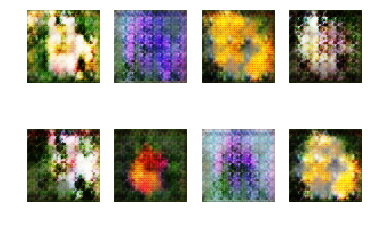

INFO:root:Epoch # : 160
INFO:root:discriminator loss = 1.102705, generator loss = 1.328637, epoch 160


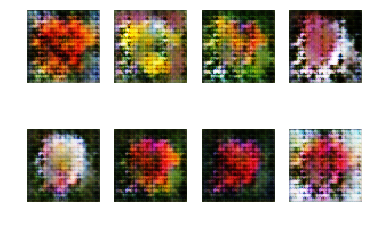

INFO:root:Epoch # : 170
INFO:root:discriminator loss = 1.231420, generator loss = 1.100620, epoch 170


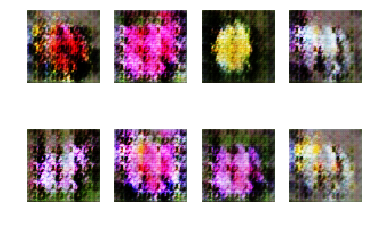

INFO:root:Epoch # : 180
INFO:root:discriminator loss = 1.197486, generator loss = 0.915260, epoch 180


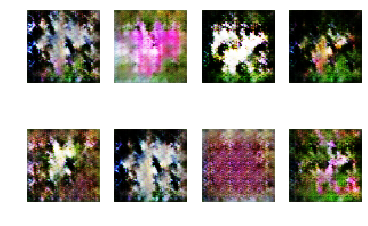

INFO:root:Epoch # : 190
INFO:root:discriminator loss = 1.181764, generator loss = 1.353013, epoch 190


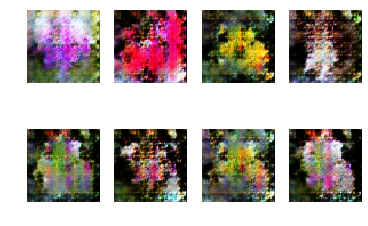

INFO:root:Epoch # : 200
INFO:root:discriminator loss = 1.326480, generator loss = 1.422071, epoch 200


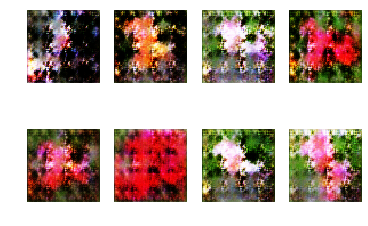

In [22]:
counter = 0
for epoch in range(epochs + 1):
    starttime = time.time()
        
    for idx, data in enumerate(train_dataloader):
        batch_start_time = time.time()
        #get real data and the input to the generator.
        real_data = gluon.utils.split_and_load(data=data, ctx_list=ctx, even_split=False)
        generator_input = create_generator_input()
        
        ############################
        # (1) Update Discriminator network: maximize log(D(x)) + log(1 - D(G(z)))
        ############################
        with autograd.record():
            output_real = [discriminator(d_) for d_ in real_data]
            d_error_real    = [loss(pred, label) for pred, label in zip(output_real, real_label)]
            error_real = 0
            for l_ in d_error_real:
                error_real += (np.asscalar(l_.mean().asnumpy()) / len(ctx))
                # The division by len(ctx) is to average out the errors accross all the devices
            
            metric.update(real_label, output_real)
                
            # create fake image and input it to discriminator
            fake_image = [generator(g_).detach() for g_ in generator_input]
            
            # We use detach() so that we don't update the Generator graph in this step.
            output_fake = [discriminator(f_image) for f_image in fake_image]
            d_error_fake = [loss(fake_pred, label) for fake_pred, label in zip(output_fake, fake_label)]     
            
            error_fake = 0
            for l_ in d_error_fake:
                error_fake += (np.asscalar(l_.mean().asnumpy()) / len(ctx))
            
            metric.update(fake_label, output_fake)      
            
            total_d_error = error_real + error_fake
            # Backward pass on the error incurred in this step.
            for (loss_real, loss_fake) in zip(d_error_real, d_error_fake):
                l = loss_real + loss_fake
                l.backward()
                

        d_trainer.step(batch_size)
        
        ############################
        # (2) Update Generator network: maximize log(D(G(z)))
        ############################
        generator_input = create_generator_input()
        with autograd.record():
            fake_image = [generator(g_) for g_ in generator_input]
            output_fake = [discriminator(f_image) for f_image in fake_image]
            g_error = [loss(fake_pred, label) for fake_pred, label in zip(output_fake, real_label)]    
            total_g_error = 0
            for l_ in g_error:
                total_g_error += (np.asscalar(l_.mean().asnumpy()) / len(ctx))
            
            # Backward pass on the error incurred in this step.
            for l_ in g_error:
                l_.backward()
                
        g_trainer.step(batch_size)

        # Print log infomation every 100 batches
        if idx != 0 and idx % 100 == 0:
            count = idx + 1
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - batch_start_time)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at epoch %d' 
                     %(total_d_error,total_g_error, acc, epoch))
        btic = time.time()
        
    name, acc = metric.get()
    metric.reset()
    if epoch % 10 == 0:
        num_image = 8
        logging.info('Epoch # : %d' %(epoch))
        logging.info('discriminator loss = %f, generator loss = %f, epoch %d' 
                     %(total_d_error,total_g_error, epoch))
        for i in range(num_image):
            latent_z = mx.nd.random_normal(0, 1, shape=(1, z_dim, 1, 1), ctx=ctx[0])
            img = generator(latent_z)
            plt.subplot(2,4,i+1)
            visualize(img[0])
        plt.show()
        
#     logging.info('Epoch end. Total time for this epoch : %f (seconds)' %(time.time() - starttime))

We can save the model by calling `save_parameters` API.

In [23]:
discriminator.save_parameters('dcgan_discriminator_latest_{}.params'.format(w.value))
generator.save_parameters('dcgan_generator_latest_{}.params'.format(w.value))

The saved model can be loaded using `load_parameters` API. 
eg : 

```discriminator.load_parameters('infogan_d_latest.params', ctx=ctx, allow_missing=True, ignore_extra=True)```

After training the GAN, visualize to see what the Generator learnt and what it generates as a stand-alone network.

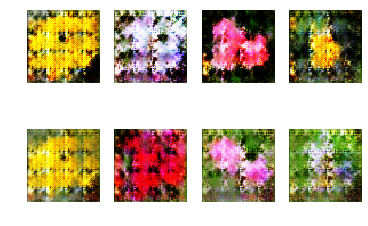

In [24]:
num_image = 8
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, z_dim, 1, 1), ctx=ctx[0])
    img = generator(latent_z)
    plt.subplot(2,4,i+1)
    visualize(img[0])
plt.show()

We can also interpolate linearly between points in latent space and can visualize the corresponding images. 
Small changes in latent space results in smooth changes in generated images.

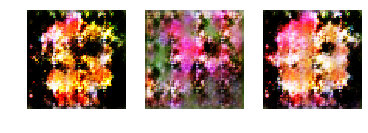

In [30]:
latent_z_1 = mx.nd.random_normal(0, 1, shape=(1, z_dim, 1, 1), ctx=ctx[0])
img_1 = generator(latent_z_1)
plt.subplot(1, 3, 1)
visualize(img_1[0])

latent_z_2 = mx.nd.random_normal(0, 1, shape=(1, z_dim, 1, 1), ctx=ctx[0])
img_2 = generator(latent_z_2)
plt.subplot(1, 3, 2)
visualize(img_2[0])


latent_z_3 = latent_z_1 + latent_z_2
img_3 = generator(latent_z_3)
plt.subplot(1, 3, 3)
visualize(img_3[0])

plt.show()